This Jupyter Notebook evaluates how much an investor's holdings would increase in value if they solely bought and sold Tesla shares based on standard RSI thresholds.

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from datetime import datetime
import mplfinance as mfp
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import stock data
start = datetime(2010,7,2)
end = datetime(2022,6,1)
pdr_data = pdr.DataReader("TSLA",'yahoo',start,end)
pdr_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-07-02,4.620000,3.742000,4.600000,3.840000,25699000.0,3.840000
2010-07-06,4.000000,3.166000,4.000000,3.222000,34334500.0,3.222000
2010-07-07,3.326000,2.996000,3.280000,3.160000,34608500.0,3.160000
2010-07-08,3.504000,3.114000,3.228000,3.492000,38557000.0,3.492000
2010-07-09,3.580000,3.310000,3.516000,3.480000,20253000.0,3.480000
...,...,...,...,...,...,...
2022-05-25,669.320007,623.010010,623.849976,658.799988,30713100.0,658.799988
2022-05-26,718.669983,653.659973,661.419983,707.729980,35334400.0,707.729980
2022-05-27,759.799988,720.530029,723.250000,759.630005,29765000.0,759.630005


In [3]:
#need to set the index of the dataframe to an integer for the loop below
pdr_data.reset_index(inplace=True)

In [4]:
#Calculate RSI using method from the below webpage:
#https://www.omnicalculator.com/finance/rsi#:~:text=Calculate%20relative%20strength%20(RS)%20by,1%20%2D%20RS)%20from%20100.

#Set RSI period, 'x'
x = 14
up_tot = 0
down_tot = 0

pdr_data['Day_Delta'] = pdr_data['Close'] - pdr_data['Close'].shift(+1)

pdr_data['Gains'] = np.where(pdr_data['Day_Delta'] > 0,pdr_data['Day_Delta'],0)
pdr_data['Losses'] = np.where(pdr_data['Day_Delta'] < 0,-pdr_data['Day_Delta'],0)

#Determine initial RSI
for df_pos in range(1,x+1): #Range is 1 to x+1 as the first row is skipped as Day_Delta is NaN
    up_tot = up_tot + pdr_data.loc[df_pos, 'Gains']
    down_tot = down_tot + pdr_data.loc[df_pos, 'Losses']
    
pdr_data.loc[x, 'Avg_Gains'] = up_tot/x
pdr_data.loc[x, 'Avg_Losses'] = down_tot/x
pdr_data.loc[x, 'RS'] = pdr_data.loc[x, 'Avg_Gains'] / pdr_data.loc[x, 'Avg_Losses']
pdr_data.loc[x,'RSI'] = 100 - 100/(1+pdr_data.loc[x, 'RS'])

#Determine the rest of the RSI values
for df_pos in range(x+1,len(pdr_data)):
    pdr_data.loc[df_pos, 'Avg_Gains'] = (pdr_data.loc[df_pos-1, 'Avg_Gains']*13 + pdr_data.loc[df_pos, 'Gains'])/x
    pdr_data.loc[df_pos, 'Avg_Losses'] = (pdr_data.loc[df_pos-1, 'Avg_Losses']*13+pdr_data.loc[df_pos, 'Losses'])/x
    pdr_data.loc[df_pos, 'RS'] = pdr_data.loc[df_pos, 'Avg_Gains'] / pdr_data.loc[df_pos, 'Avg_Losses']
    pdr_data.loc[df_pos,'RSI'] = 100 - 100/(1+pdr_data.loc[df_pos, 'RS'])

pdr_data[['Date','Close','Day_Delta','Gains','Losses','Avg_Gains','Avg_Losses','RS','RSI']].tail()

,Date,Close,Day_Delta,Gains,Losses,Avg_Gains,Avg_Losses,RS,RSI
2995,2022-05-25,658.799988,30.640015,30.640015,0.000000,11.224356,21.905959,0.512388,33.879413
2996,2022-05-26,707.729980,48.929993,48.929993,0.000000,13.917616,20.341247,0.684207,40.624862
2997,2022-05-27,759.630005,51.900024,51.900024,0.000000,16.630645,18.888301,0.880473,46.821899
2998,2022-05-31,758.260010,-1.369995,0.000000,1.369995,15.442742,17.636993,0.875588,46.683390
2999,2022-06-01,740.369995,-17.890015,0.000000,17.890015,14.339689,17.655066,0.812214,44.818874


In [5]:
#Set overbought and oversold thresholds
overbought_thresh = 70
oversold_thresh = 30
pdr_data['Overbought'] = overbought_thresh
pdr_data['Oversold'] = oversold_thresh

In [6]:
#Buy-Sell Model
own_shares = False #assumes you start off WITHOUT any shares, waiting for RSI < oversold threshold
start_amount = float(1)
current_amount = start_amount

for df_pos in range(0, len(pdr_data)):
    
    #Buy conditions
    if own_shares == False and pdr_data.loc[df_pos, 'RSI'] < oversold_thresh:
        
        buy_price = pdr_data.loc[df_pos, 'Close'] #Assumes the buy is at the close price of the day RSI is evaluated
        own_shares = True
        pdr_data.loc[df_pos,'Buy'] = buy_price
        print('Buy Date:',(pdr_data.loc[df_pos, 'Date']).strftime("%Y-%m-%d"),'RSI:',round(pdr_data.loc[df_pos, 'RSI'],2),'Close:',round(pdr_data.loc[df_pos, 'Close'],2), 'Holdings:', round(current_amount,2))
    
    #Sell conditions
    elif own_shares == True and pdr_data.loc[df_pos, 'RSI'] > overbought_thresh:
        
        sell_price = pdr_data.loc[df_pos, 'Close'] #Assumes the sell is at the close price of the day RSI is evaluated
        current_amount = (sell_price/buy_price) * current_amount
        pdr_data.loc[df_pos,'Sell'] = sell_price
        own_shares = False
        print('Sell Date:',(pdr_data.loc[df_pos, 'Date']).strftime("%Y-%m-%d"),'RSI:',round(pdr_data.loc[df_pos, 'RSI'],2),'Close:',round(pdr_data.loc[df_pos, 'Close'],2), 'Holdings:', round(current_amount,2))
    
    pdr_data.loc[df_pos, 'Holdings'] = current_amount
    pdr_data.loc[df_pos, 'Own'] = own_shares

Buy Date: 2011-01-20 RSI: 29.04 Close: 4.52 Holdings: 1.0
Sell Date: 2011-03-31 RSI: 74.3 Close: 5.55 Holdings: 1.23
Buy Date: 2011-08-08 RSI: 28.14 Close: 4.73 Holdings: 1.23
Sell Date: 2011-11-03 RSI: 72.49 Close: 6.49 Holdings: 1.68
Buy Date: 2012-01-13 RSI: 23.69 Close: 4.56 Holdings: 1.68
Sell Date: 2012-02-17 RSI: 72.0 Close: 6.99 Holdings: 2.58
Buy Date: 2013-11-18 RSI: 27.92 Close: 24.32 Holdings: 2.58
Sell Date: 2014-01-22 RSI: 70.45 Close: 35.71 Holdings: 3.8
Buy Date: 2014-12-08 RSI: 29.67 Close: 42.87 Holdings: 3.8
Sell Date: 2015-04-27 RSI: 75.08 Close: 46.31 Holdings: 4.1
Buy Date: 2015-10-12 RSI: 28.15 Close: 43.12 Holdings: 4.1
Sell Date: 2016-03-15 RSI: 70.08 Close: 43.67 Holdings: 4.15
Buy Date: 2016-05-12 RSI: 29.98 Close: 41.46 Holdings: 4.15
Sell Date: 2016-12-23 RSI: 71.22 Close: 42.67 Holdings: 4.27
Buy Date: 2017-11-02 RSI: 27.86 Close: 59.85 Holdings: 4.27
Sell Date: 2018-06-12 RSI: 71.35 Close: 68.55 Holdings: 4.9
Buy Date: 2018-09-07 RSI: 27.16 Close: 52.65 H

In [7]:
#Need to reset the index to the date for the graph to work properly
pdr_data.set_index('Date',inplace=True)

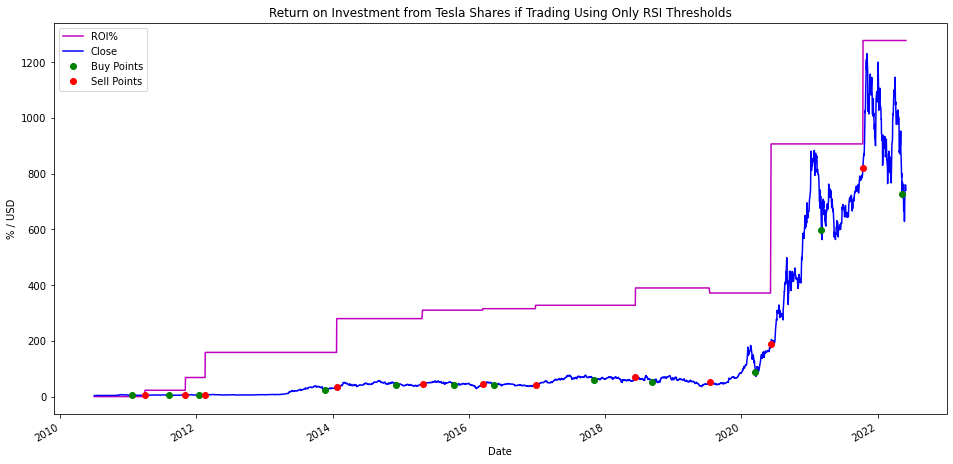

In [8]:
#Plot earnings
((pdr_data['Holdings']-1)*100).plot(label='ROI%',figsize=(16,8), color ='m')
pdr_data['Close'].plot(label='Close',color='b')
pdr_data['Buy'].plot(label='Buy Points', linestyle=' ', marker='o', color='g')
pdr_data['Sell'].plot(label='Sell Points', linestyle=' ', marker='o', color='r')

_=plt.xlabel('Date')
_=plt.ylabel('% / USD')
_=plt.title('Return on Investment from Tesla Shares if Trading Using Only RSI Thresholds')
plt.legend();